<a href="https://colab.research.google.com/github/AnaBelenCarbajal/Thesis-Experiment-3/blob/main/Phase2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset novel shapes - Trainig**

1) Installing packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install osculari

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 7.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nv

In [ ]:
#packages
import osculari
from osculari.paradigms.forced_choice import paradigm_utils
import torch.nn as nn

import os
import pandas as pd
import torch
import numpy as np
from matplotlib import pyplot as plt

from random import choice
import torchvision.transforms.functional as transform
from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms import v2
from torchvision.transforms import Pad
from torch.utils.data import DataLoader

from PIL import Image

In [ ]:
# unzip folder (previously uploaded in collab)
!unzip '/content/drive/MyDrive/Thesis/Neural_network/Human category learning task/documents/CategoryLearningStimuli.zip' -d my_data

Archive:  /content/drive/MyDrive/Thesis/Neural_network/Human category learning task/documents/CategoryLearningStimuli.zip
   creating: my_data/CategoryLearningStimuli/
  inflating: my_data/__MACOSX/._CategoryLearningStimuli  
  inflating: my_data/CategoryLearningStimuli/348.png  
  inflating: my_data/__MACOSX/CategoryLearningStimuli/._348.png  
  inflating: my_data/CategoryLearningStimuli/360.png  
  inflating: my_data/__MACOSX/CategoryLearningStimuli/._360.png  
  inflating: my_data/CategoryLearningStimuli/176.png  
  inflating: my_data/__MACOSX/CategoryLearningStimuli/._176.png  
  inflating: my_data/CategoryLearningStimuli/88.png  
  inflating: my_data/__MACOSX/CategoryLearningStimuli/._88.png  
  inflating: my_data/CategoryLearningStimuli/162.png  
  inflating: my_data/__MACOSX/CategoryLearningStimuli/._162.png  
  inflating: my_data/CategoryLearningStimuli/189.png  
  inflating: my_data/__MACOSX/CategoryLearningStimuli/._189.png  
  inflating: my_data/CategoryLearningStimuli/77.pn

In [ ]:
# root directory to data
root = "my_data/CategoryLearningStimuli/"
dic_pretraining = '/content/drive/MyDrive/Thesis/Neural_network/Pre-training on Animals shapes/'
dic_training = '/content/drive/MyDrive/Thesis/Neural_network/Human category learning task/texture fine-tune test/'

In [ ]:
# get category labels
image_ID = os.listdir(root)

#remove ".DS_Store"
image_ID.remove(".DS_Store")
#image_ID.remove(".ipynb_checkpoints")

2) Defining parameters

In [ ]:
# conditions
condition1 = {
    'A':[-30, 30],  #low var
    'D':[-80, 80]   #high var
    }

In [ ]:
# reference shapes angles --> categories
reference_shapeA = 0
reference_shapeD = 210

3) Get angles and directory

In [ ]:
# get angles
angles = []
for image in image_ID:
  get_angle = image.replace('.png', '')
  transform_to_int = int(get_angle)
  angles.append(transform_to_int)

In [ ]:
# get image directories
img_dir = []

for image in image_ID:
  folder_path = root + image
  img_dir.append(folder_path)

4) Create general dataset

In [ ]:
data =  {'angle' : angles,
         'image' : image_ID,
         'img_dir' : img_dir}
# df
df_data = pd.DataFrame(data)
df_data = df_data.sort_values('angle')

5) Define functions to create dataset for cond1 and cond2 with corresponding labels of whether the shapes belong to the same condition as Reference shapes A, B, C and D

In [ ]:
# functions to create datasets

# create datasets for reference shape A and D
def CreateLabelsAD (reference_shape, condition, dataset, stringCat):
  angles = dataset['angle'].tolist()
  labels = []

  for angle in angles:

    left_threshold = reference_shape + condition[stringCat][0]
    right_threshold = reference_shape + condition[stringCat][1]

    if stringCat == "A":
      left_threshold = left_threshold + 360
      if angle >= left_threshold or angle <= right_threshold:
        label_composition = "sameCat-A"
        label = label_composition
      else:
        label_composition = "diffCat-A"
        label = label_composition
    else:
      if angle >= left_threshold and angle <= right_threshold:
        label_composition = "sameCat-D"
        label = label_composition
      else:
        label_composition = "diffCat-D"
        label = label_composition

    labels.append(label)
  return labels

  # Create dictionary data
def CreateDictionary (dataframe):
  data_dicts = []

  for i in range(len(dataframe)):
    angle = dataframe.iloc[i, 0]
    image = dataframe.iloc[i, 1]
    img_dir = dataframe.iloc[i, 2]
    labels = dataframe.iloc[i, 3]
    ref_shape = dataframe.iloc[i, 4]

    individual_dic =  {'angle' : angle,
                       'image' : image,
                       'img_dir' : img_dir,
                       'label' : labels,
                       'RS': ref_shape}

    data_dicts.append(individual_dic)
  return data_dicts

6) Create datasets (4 for each condition)

In [ ]:
# COND1 : getting labels for each reference shape

#refA
labels_RefA_Cond1 = CreateLabelsAD(reference_shapeA, condition1, df_data, "A")
#refD
labels_RefD_Cond1 = CreateLabelsAD(reference_shapeD, condition1, df_data, "D")

# create dataframe for each RS
df_data_RSA = df_data.copy()
df_data_RSD = df_data.copy()

# add labels to df
df_data_RSA["label"] = labels_RefA_Cond1
df_data_RSD["label"] = labels_RefD_Cond1

# add column with RS
df_data_RSA["RS"] = 'RS-A'
df_data_RSD["RS"] = 'RS-D'

df_data_cond1 = pd.concat([df_data_RSA,df_data_RSD])

In [ ]:
data_Cond1 = CreateDictionary(df_data_cond1)
data_Cond1[0]

{'angle': 0,
 'image': '0.png',
 'img_dir': 'my_data/CategoryLearningStimuli/0.png',
 'label': 'sameCat-A',
 'RS': 'RS-A'}

7) Create and select random positions for images

In [ ]:
# read positions.txt
#read
PATH = '/content/drive/MyDrive/Thesis/Neural_network/Human category learning task/documents/positions.txt'
positions = np.loadtxt(PATH)
positions = positions.tolist()
positions = [[int(float(j)) for j in i] for i in positions]
positions[:5]

[[23, 25, 21, 19],
 [26, 26, 18, 18],
 [31, 7, 13, 37],
 [27, 5, 17, 39],
 [31, 10, 13, 34]]

8) Define class for CNN

In [ ]:
# function to gove 'random' color jitter
import torch
from torchvision import transforms
from torchvision.transforms import functional as F

def compute_parameters(brightness, contrast, saturation, hue): #tuples
  # pool size of static random values
  N_values = 1000

  # Create list of random values
  rng = np.random.default_rng(seed=42)
  brightness = list(rng.uniform(low=brightness[0], high=brightness[1], size=(N_values,)))
  contrast = list(rng.uniform(low=contrast[0], high=contrast[1], size=(N_values,)))
  saturation = list(rng.uniform(low=saturation[0], high=saturation[1], size=(N_values,)))
  hue = hue

  # Define specific jitter values
  brightness_factor = np.random.choice(brightness)  # Change this to your specific value
  contrast_factor = np.random.choice(contrast)    # Change this to your specific value
  saturation_factor = 0.8  # Change this to your specific value
  hue_factor = 0.1         # Change this to your specific value

  return brightness_factor, contrast_factor, saturation_factor, hue_factor


def apply_ColorJitter(tensor, brightness_factor, contrast_factor, saturation_factor, hue_factor):

  # Convert tensor to PIL Image
  pil_image = transforms.ToPILImage()(tensor)

  # Apply the transformations using functional API on PIL image
  jittered_image = F.adjust_brightness(pil_image, brightness_factor)
  jittered_image = F.adjust_contrast(jittered_image, contrast_factor)
  jittered_image = F.adjust_saturation(jittered_image, saturation_factor)
  jittered_image = F.adjust_hue(jittered_image, hue_factor)

  # Convert PIL Image back to tensor
  jittered_tensor = transforms.ToTensor()(jittered_image)

  return jittered_tensor

In [ ]:
class ShapeImageDataset (Dataset):
  # return two images, with 50% chance in same or different category and ground truth

  # __init__
  def __init__(self, length, data_dict, positions, transform=None):
    self.length = length
    self.data = data_dict
    self.transform = transform
    self.positions = positions
    self.left_right = [1, 0]
    self.same_category = [1, 0]

  # __len__
  def __len__(self):
    return self.length

  # funtion to get idx within 0 and 722
  def centered_angle (self, idx):
    if idx < 722:
      centered_angle = idx
    elif idx == 722:
      centered_angle = 0
    elif idx > 722 and idx < (722*2):
      centered_angle = idx - (722)
    elif idx == 722*2:
      centered_angle = 0
    elif idx > (722*2) and idx < (722*3):
      centered_angle = idx - (722*2)
    else: # idx == (722*3)
      centered_angle = 0
    return centered_angle

  # function to pick image from 'diffCat'
  def select_Cat_image(self, data, category):
    result = []
    for item in data:
      if item['label'] == category:
        result.append(item)
    return choice(result)

  # function to read images
  def read_image_from_directory(self, img_dir):
    return read_image(img_dir, ImageReadMode.RGB)

  # __getitem__
  def __getitem__(self, idx):

    # get idx btw 0 and 721
    idx_centered = self.centered_angle(idx)
    row_idx_centered = self.data[idx_centered]

    if row_idx_centered['RS'] == 'RS-A':
      reference_shape = reference_shapeA
    else:
      reference_shape = reference_shapeD + 361

    # img1 should be reference shape
    ref_shape_image = self.data[reference_shape]
    ref_shape_label = ref_shape_image['label']
    ref_shape_dir = ref_shape_image['img_dir']
    ref_shape_angle = ref_shape_image['angle']

    # get test shape
    test_shape_image = row_idx_centered

    # 50-50 choose image 2 from same category
    same = choice(self.same_category)
    # if gt = 1
    if same == 1:
      # if label matches:
      if test_shape_image['label'] == ref_shape_label:
        pass
      #if labels do not match
      else:
        # make sure get right reference shape
        if reference_shape == reference_shapeA:
          test_shape_image = self.select_Cat_image(self.data, 'sameCat-A')
        else:
          test_shape_image = self.select_Cat_image(self.data, 'sameCat-D')
    # if gt = 0
    else:
      # if labels do not match
      if test_shape_image['label'] != ref_shape_label:
        pass
      # if labels match
      else:
        # make sure rught reference shape
        if reference_shape == reference_shapeA:
          test_shape_image = self.select_Cat_image(self.data, 'diffCat-A')
        else:
          test_shape_image = self.select_Cat_image(self.data, 'diffCat-D')

    # get test shape label and directory
    test_shape_label = test_shape_image['label']
    test_shape_dir = test_shape_image['img_dir']

    # read images
    img1 = self.read_image_from_directory(ref_shape_dir)
    img2 = self.read_image_from_directory(test_shape_dir)

    # gt
    if ref_shape_label == test_shape_label:
      gt = 1
    else:
      gt = 0

    # apply transformations
    # resize to 180x180
    resize = v2.Resize([180,180])
    img1 = resize(img1)
    img2 = resize(img2)
    # apply padding
    img1_selected_position = choice(self.positions)
    img2_selected_position = choice(self.positions)
    padding_img1 = Pad(padding = img1_selected_position, fill=128)
    padding_img2 = Pad(padding = img2_selected_position, fill=128)
    img1 = padding_img1(img1)
    img2 = padding_img2(img2)

    #apply ColorJitter
    [brightness_factor, contrast_factor, saturation_factor, hue_factor] = compute_parameters(
        brightness=(0.5,0.8), contrast=(0.1,1), saturation=(-0.5,0.5), hue=0)
    img1 = apply_ColorJitter(img1, brightness_factor, contrast_factor, saturation_factor, hue_factor)
    img2 = apply_ColorJitter(img2, brightness_factor, contrast_factor, saturation_factor, hue_factor)

    # apply more transformations
    if self.transform:
      img1 = self.transform(img1)
      img2 = self.transform(img2)

    # left and right positions change randomly
    # return tensors for image 1 and image 2 and a ground truth
    if choice(self.left_right) == 1:
      img_left = img1
      img_right = img2
    else:
      img_left = img2
      img_right = img1

    #return to_grayscale_rgb(img_left), to_grayscale_rgb(img_right), gt
    return img_left, img_right, gt

9) Create datasets of images

In [ ]:
# tranformations to images for NN
preprocess = v2.Compose(
    [   v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [ ]:
# TEST
#parameters: length, reference_shape, test_shape, data_dict, positions, transform=None)
len_dataset = 722*3 # multiple of 722
dataset = ShapeImageDataset(len_dataset, data_Cond1, positions, preprocess)
dataset[722*2]

(tensor([[[-0.9877, -0.9877, -0.9877,  ..., -0.9877, -0.9877, -0.9877],
          [-0.9877, -0.9877, -0.9877,  ..., -0.9877, -0.9877, -0.9877],
          [-0.9877, -0.9877, -0.9877,  ..., -0.9877, -0.9877, -0.9877],
          ...,
          [-0.9877, -0.9877, -0.9877,  ..., -0.9877, -0.9877, -0.9877],
          [-0.9877, -0.9877, -0.9877,  ..., -0.9877, -0.9877, -0.9877],
          [-0.9877, -0.9877, -0.9877,  ..., -0.9877, -0.9877, -0.9877]],
 
         [[-0.8803, -0.8803, -0.8803,  ..., -0.8803, -0.8803, -0.8803],
          [-0.8803, -0.8803, -0.8803,  ..., -0.8803, -0.8803, -0.8803],
          [-0.8803, -0.8803, -0.8803,  ..., -0.8803, -0.8803, -0.8803],
          ...,
          [-0.8803, -0.8803, -0.8803,  ..., -0.8803, -0.8803, -0.8803],
          [-0.8803, -0.8803, -0.8803,  ..., -0.8803, -0.8803, -0.8803],
          [-0.8803, -0.8803, -0.8803,  ..., -0.8803, -0.8803, -0.8803]],
 
         [[-0.6541, -0.6541, -0.6541,  ..., -0.6541, -0.6541, -0.6541],
          [-0.6541, -0.6541,

**Plotting Dataset**

In [ ]:
# Denormalize tensor
denormalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

In [ ]:
from torchvision.transforms import functional as F

def tensor_to_pil(image_tensor):
    return F.to_pil_image(image_tensor)

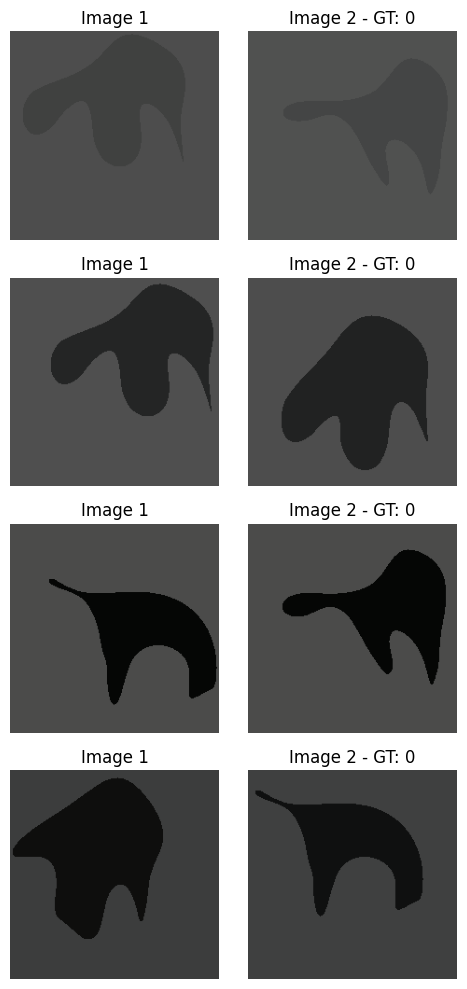

In [ ]:
# Example usage to display 5 pairs of images
fig, axs = plt.subplots(4, 2, figsize=(5, 10))

for i in range(4):
    idx = np.random.randint(0, len(dataset) - 1)
    img1, img2, gt = dataset[idx]  # Get image pair and ground truth
    img1 = denormalize(img1)
    img2 = denormalize(img2)
    img1_pil = tensor_to_pil(img1)
    img2_pil = tensor_to_pil(img2)

    axs[i, 0].imshow(img1_pil)
    axs[i, 0].set_title('Image 1')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(img2_pil)
    axs[i, 1].set_title(f'Image 2 - GT: {gt}')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.savefig(dic_training + 'training_RSA&D_4.pdf')
plt.show()

**Neural network**

Get pre-trained weights

In [ ]:
# COND1
#create dataset for RSA and RSD
#parameters: length, reference_shape, test_shape, data_dict, positions, transform=None)
len_dataset = 722*3 # multiple of 722
dataset = ShapeImageDataset(len_dataset, data_Cond1, positions, preprocess)

In [ ]:
# dataset loader
dataset_loader = DataLoader(dataset, 64)

In [ ]:
# experiment-dependent function to process an epoch of data
epoch_fun = osculari.paradigms.forced_choice.epoch_loop

In [ ]:
lr = 0.01

In [ ]:
dic_models = '/content/drive/MyDrive/Thesis/Neural_network/Pre-training on Animals shapes/fine-tuned models/tex-color fine-tuned/'
#load pretrained weights
resnet_animal_weights = 'Tex_resnet_animal_layer0_NP.pt'
clip_animal_weights = 'Tex_clip_animal_layer0_NP.pt'
clipViT_animal_weightsP = 'Tex_clipViT_animal_layer0_NP.pt'

# load weights
def load_weights(model):
  PATH = dic_models + model
  pretrained_weights = torch.load(PATH)
  return pretrained_weights

In [ ]:
res_weights = load_weights(resnet_animal_weights)
clip_weights = load_weights(clip_animal_weights)
clipViT_weights = load_weights(clipViT_animal_weightsP)

Training

In [ ]:
##############################################
# Resnet
##############################################

# network
architecture = 'resnet50'        # network's architecture
weights = 'resnet50'             # the pretrained weights
img_size = 224                   # network's input size
layer = 'block0'                    # the readout layer
pooling = None
readout_kwargs = {               # parameters for extracting features from the pretrained network
    'architecture': architecture,
    'weights': weights,
    'layers': layer,
    'img_size': img_size,
    'pooling': pooling
}

# model with pre-trained weights
layer0_NP_res = osculari.models.paradigm_2afc_merge_concatenate(**readout_kwargs)

In [ ]:
# RSA-D
layer0_NP_res.load_state_dict(res_weights)

params_to_optimize = [{'params': [p for p in layer0_NP_res.fc.parameters()]}]
optimiser = torch.optim.SGD(params_to_optimize, lr=lr, momentum=0.9, weight_decay=1e-4)

# calling the generic train_linear_probe function
training_log = osculari.paradigms.paradigm_utils.train_linear_probe(
    layer0_NP_res, dataset_loader, epoch_fun, 'my_data/osculari_test/', device="cuda",
    epochs = 10,
    optimiser=optimiser
    )

[000] accuracy=0.508 loss=69268.023
[001] accuracy=0.518 loss=40161.564
[002] accuracy=0.543 loss=24320.736
[003] accuracy=0.514 loss=60240.758
[004] accuracy=0.510 loss=47446.954
[005] accuracy=0.566 loss=19863.318
[006] accuracy=0.614 loss=14070.727
[007] accuracy=0.597 loss=12455.984
[008] accuracy=0.608 loss=9415.764
[009] accuracy=0.597 loss=8235.859


In [ ]:
# save model's weigths
PATH = dic_training + 'Training on RS-A and RS-D/' + 'res_training_RSA-D.pt'
torch.save(layer0_NP_res.state_dict(), PATH)

In [ ]:
##############################################
# CLIP
##############################################

# network
architecture = 'clip_RN50'        # network's architecture
weights = 'clip_RN50'             # the pretrained weights
img_size = 224                   # network's input size
layer = 'block0'                    # the readout layer
pooling = None
readout_kwargs = {               # parameters for extracting features from the pretrained network
    'architecture': architecture,
    'weights': weights,
    'layers': layer,
    'img_size': img_size,
    'pooling': pooling
}

# model with pre-trained weights
layer0_NP_clip = osculari.models.paradigm_2afc_merge_concatenate(**readout_kwargs)

100%|███████████████████████████████████████| 244M/244M [00:02<00:00, 86.8MiB/s]


In [ ]:
# RSA-D
layer0_NP_clip.load_state_dict(clip_weights)

params_to_optimize = [{'params': [p for p in layer0_NP_clip.fc.parameters()]}]
optimiser = torch.optim.SGD(params_to_optimize, lr=lr, momentum=0.9, weight_decay=1e-4)

# calling the generic train_linear_probe function
training_log = osculari.paradigms.paradigm_utils.train_linear_probe(
    layer0_NP_clip, dataset_loader, epoch_fun, 'my_data/osculari_test/', device="cuda",
    epochs = 10,
    optimiser=optimiser
    )

[000] accuracy=0.503 loss=2823.541
[001] accuracy=0.500 loss=5851.321
[002] accuracy=0.511 loss=4568.062
[003] accuracy=0.488 loss=5760.620
[004] accuracy=0.539 loss=2824.471
[005] accuracy=0.555 loss=569.176
[006] accuracy=0.586 loss=364.254
[007] accuracy=0.545 loss=416.857
[008] accuracy=0.612 loss=249.799
[009] accuracy=0.607 loss=269.345


In [ ]:
# save model's weigths
PATH = dic_training + 'Training on RS-A and RS-D/' + 'clip_training_RSA-D.pt'
torch.save(layer0_NP_clip.state_dict(), PATH)